## Mitigatin the Fairness Issues using In-Processing: Exponentiated Gradients

Exponentiated gradient method focuses on optimizing the model's performance while minimizing disparities between sensitive groups.

In [11]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover
from sklearn.pipeline import Pipeline
from fairlearn.reductions import DemographicParity, ExponentiatedGradient


In [13]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=y['Loan_Approval'], y_pred=y['Loan_Approval'], sensitive_features=X['Sex']
)

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_train = X_train['Sex']
sensitive_test = X_test['Sex']

The Exponentiated Gradients method can be applied on a sklearn pipeline. Here for simplicity, our pipeline only includes a classifier, but you might include also some preprocessing steps.

In [18]:
pipeline = Pipeline(
    steps=[
        ("classifier",RandomForestClassifier(random_state=42)),
    ]
)

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=DemographicParity(),
    sample_weight_name="classifier__sample_weight"
)
exponentiated_gradient.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred = exponentiated_gradient.predict(X_test)

In [26]:
# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8591269841269842


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

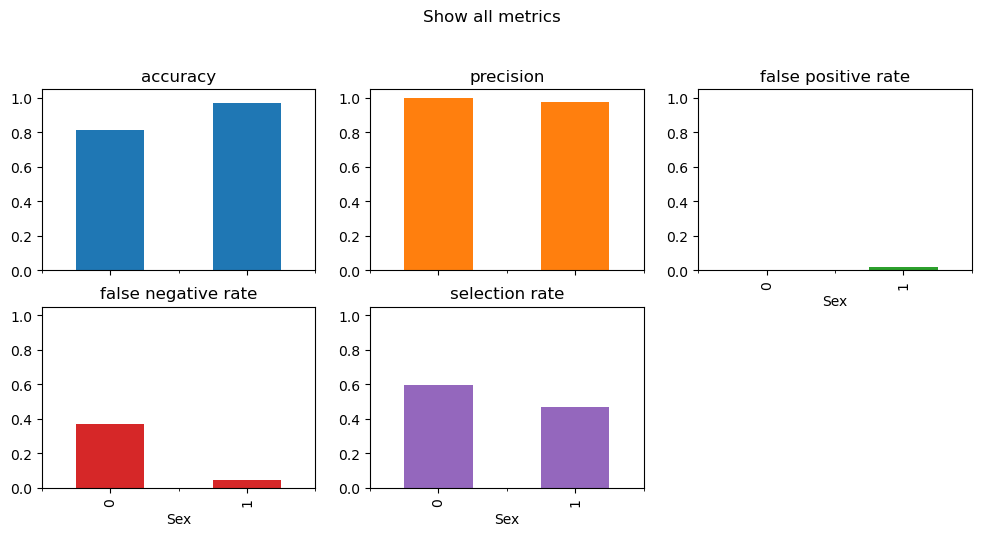

In [28]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)


In [30]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.12740384615384615
Statistical Parity ratio: 0.7862903225806451
Equalized Odds Difference: 0.323868677905945
Equalized Odds Ratio: 0.0


**Exercise 4.5:** Have alook at the documentation of Exponentiated Gradients function in Fairlearn at https://fairlearn.org/v0.9/api_reference/generated/fairlearn.reductions.ExponentiatedGradient.html and learn more about how to use it. Name its hyperparameters and explain how they might affact the final model.

In [47]:
text = """The 'ExponentiatedGradient' method in Fairlearn 
adjusts model training to satisfy fairness constraints. 
It has a few key hyperparameters 
that influence how well it balances fairness and performance:

1. eps: Controls how much fairness violation is allowed. Lower values enforce stricter fairness but may reduce accuracy, while higher values allow for more flexibility.
2. max_iter: Sets the number of iterations the algorithm runs. More iterations can lead to better results but take more time.
3. nu: This is the convergence threshold. A smaller value means more precision but slower optimization.
4. eta0: This is the initial learning rate. Higher values speed up training but risk overshooting the best solution.
5. run_linprog_step: If `True`, adds an extra optimization step to improve fairness, but this increases runtime.

Tuning these hyperparameters helps control the trade-off between fairness and accuracy, allowing you to find the right balance for your model.
"""

cleaned_text = " ".join(text.splitlines())

print(cleaned_text)

The 'ExponentiatedGradient' method in Fairlearn  adjusts model training to satisfy fairness constraints.  It has a few key hyperparameters  that influence how well it balances fairness and performance:  1. eps: Controls how much fairness violation is allowed. Lower values enforce stricter fairness but may reduce accuracy, while higher values allow for more flexibility. 2. max_iter: Sets the number of iterations the algorithm runs. More iterations can lead to better results but take more time. 3. nu: This is the convergence threshold. A smaller value means more precision but slower optimization. 4. eta0: This is the initial learning rate. Higher values speed up training but risk overshooting the best solution. 5. run_linprog_step: If `True`, adds an extra optimization step to improve fairness, but this increases runtime.  Tuning these hyperparameters helps control the trade-off between fairness and accuracy, allowing you to find the right balance for your model.
